<h1><center>Histopathologic Cancer Detection by CNN</center></h1>

## Contents

**1. About the Data**

**2. Libraries**

**3. Data Import**

**4. EDA**

   (a) Cancerous Tissue
   
   (b) Non-Cancerous Tissue
   
   (c) Analysis
   
**5. Data Preprocessing**

   (a) Data Normalization and Augmentation
   
**6. Model Design and Training**

   (a) First Model
   
   (b) Second Model
   
   (c) third Model
   
**7. Hyperparameter Tuning**

   (a) Learning Rate
   
   (b) Decay
   
**8. Results and Analysis**

   (a) Optimizer & Architecture Comparison
   
   (b) Learning Rate
   
   (c) Decay
   
   *(d) Result Summary
   
**9. Kaggle Test Data Prediction**

**10. Conclusion**

## 1. About the Data

Early tumor/caner detection is paramount to effective treatment of the disease. To augment this, machine and deep learning tools are more and more widely used to assist doctors and medical staff in diagnosing these cancerous growths. The following project is also designed to identify the cancerous cells. It basically also follows the histopathology method i.e. diagnosis of cancerous cells by examination under a microscope. 

The dataset is composed of train and test dataset which contain a vast amount of histopathology images(microscopic view) which are set as a classification problem. The train data has **220025 images** whereas the test data has **57458 images**. The data has been retrieved from the kaggle. Each image has a 96 x 96 pixel quality with the design of each image in a way that the ancerous cells are near the center of the image. This condition would later help us in using pooling more effectively as well. The large size of the datset also greatly removes the need for data augmentation.

## 2. Libraries

In [41]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

In [109]:
import tensorflow as tf
# from tf import keras

import keras
import visualkeras
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dropout , Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.models import load_model

## 3.Importing Data

In [43]:
train_labels = pd.read_csv("train_labels.csv")
train_data = os.listdir("histopathologic-cancer-detection/train/")
test_data = os.listdir("histopathologic-cancer-detection/test/")
sample_submission = pd.read_csv("sample_submission.csv")

In [44]:
## route to the train and test directory to extract images later
train_rt = "histopathologic-cancer-detection/train/"
test_rt = "histopathologic-cancer-detection/test/"

In [45]:
len(train_data)

220025

In [46]:
len(test_data)

57458

In [47]:
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [48]:
sample_submission

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


## 4. Exploratory Data Analysis

<AxesSubplot:>

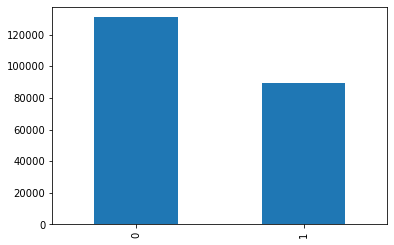

In [49]:
train_labels.label.value_counts().plot(kind = 'bar')

In [50]:
## getting the indices of cancerous and non cancerous images
cancer_ind = []
non_cancer_ind = []

for i in range(len(train_labels)):
    if train_labels.label[i] == 1:
        cancer_ind.append(i)
        
    else:
        non_cancer_ind.append(i)

### (a) Cancerous Tissue

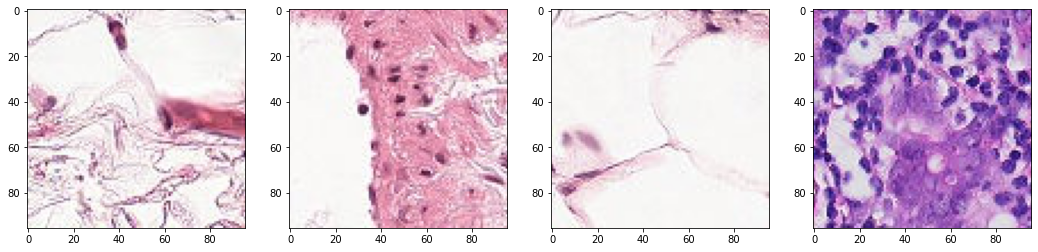

In [51]:
## taking a look at a few cancerour images
fig , ax = plt.subplots(1,4, figsize = (18,10))
for i in range(4):
    ax[i].imshow(Image.open(train_rt + train_data[cancer_ind[i]]))
    

### (b) Non Cancerous Tissue

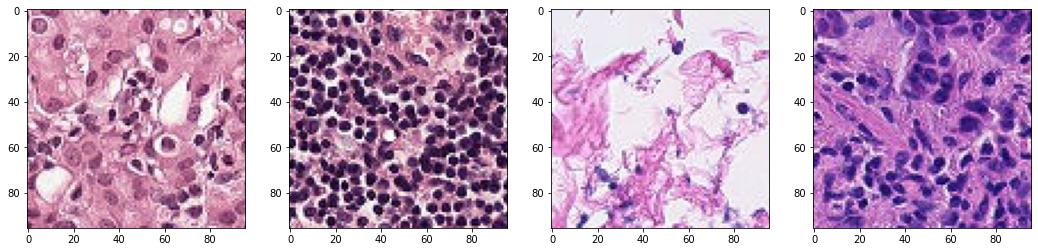

In [52]:
fig , ax = plt.subplots(1,4, figsize = (18,10))
for i in range(4):
    ax[i].imshow(Image.open(train_rt + train_data[non_cancer_ind[i]]))

### (c) Analysis

By looking at the mages, it doesn't seem to be making much sense to an untrained eye of any difference among the various images. Moreover, the cancerous and non-cancerous images do not seem to be equally divided but we will not be attemepting to equalize them since it is assumed that cancer occurence will be a lot less than non-cancer occurence, so it would not be compromising the overall accuracy of any furture model design.

## 5. Data Preprocessing

In order to pass the data to the keras model, we need to first convert it to a format where the input will be accepted by the keras model and for this we'll be using the Data genrator alongwith the data division into the various folders for train and validation.

Since the keras data generator does not support '.tif' images for split, we will have to manually divide the data into train and validation group before splitting them into label based folders for putting it into the model.

In [53]:
training , valid = train_test_split(train_labels , test_size = 0.15) 

In [54]:
## this process is vert slow since the dataset is quite large

## Converting to list to iterate over the images
t1 = training.set_index('id')
train_list = list(training['id'])

## iterating over the images and putting them into folders according to labels 0(non_cancer) and 1(cancer)
## for training
for i in train_list:
    
    image = i + '.tif'
    
    lab = t1.loc[i , 'label']
    
    if lab == 0:
        folder = 'Non_cancer'
    else:
        folder = 'Cancer'
        
    temp_src = os.path.join('histopathologic-cancer-detection/train/' , image)
    
    temp_dest = os.path.join('train/', folder , image)
    
    shutil.copyfile(temp_src , temp_dest)


In [55]:
v1 = valid.set_index('id')
valid_list = list(valid['id'])

## iterating over the images and putting them into folders according to labels 0(non_cancer) and 1(cancer)
## for validation
for i in valid_list:
    
    image = i + '.tif'
    
    lab = v1.loc[i , 'label']
    
    if lab == 0:
        folder = 'Non_cancer'
    else:
        folder = 'Cancer'
        
    temp_src = os.path.join('histopathologic-cancer-detection/train/' , image)
    
    temp_dest = os.path.join('validation/', folder , image)
    
    shutil.copyfile(temp_src , temp_dest)

### (a) Data Normalization and Augmentation

The data normalization was required since a CNN works better when the data is scaled. Moreover, an augmentation was also carried out which was seemingly trivial since the data that we have is quite large and won't require any substantive augmentation to capture as much data from the lesser number of available data to train.

In [56]:
gen = ImageDataGenerator(rescale = 1/255,
                        rotation_range = 5)

In [57]:
training_gen = gen.flow_from_directory('train',
                                      batch_size = 32,
                                      class_mode = 'binary',
                                      shuffle = True,
                                      target_size = (96,96))

valid_gen = gen.flow_from_directory('validation',
                                   batch_size = 32,
                                   class_mode = 'binary',
                                   shuffle = True,
                                   target_size = (96,96))

Found 219328 images belonging to 2 classes.
Found 84964 images belonging to 2 classes.


## 6. Model Training

The initial model architecture was designed after initialization with a single hidden layer followed by flattening and dropping out before the output being generated by the dense layer. now, lets break each layer as follows:

1. **Initial Layer:**

The first layer was taken as a convolution layer since we intended to use filters which would have made the pixels at far off distance to each other having no meaning at all. We set the filter size to 32 as an arbitrary value, stride as 2 to improve time complexity, no padding as all since images provided were designed to have the tumor tissue in the inner pixels and activation to Relu to again enhance the time complexity as opposed to the time consuming sigmoid.

We further used the MaxPool2D to reduce the size of our images by removing the redundant pixel values. We then resort to normalization of the batches to mantain an effective loss and mantaining caution against overfitting.

2. **First Hidden Layer:**

The hidden layer present also mantains the same structure as the initial layer.

3. **Output Layer:**

In the output layer, however, we first resort to dropout to improve against overfitting and flatten out to feed it to the dense layer for further output to remain linear.

### (a) First Model Built

In [58]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999), loss = 'binary_crossentropy',
              metrics = ['AUC'])



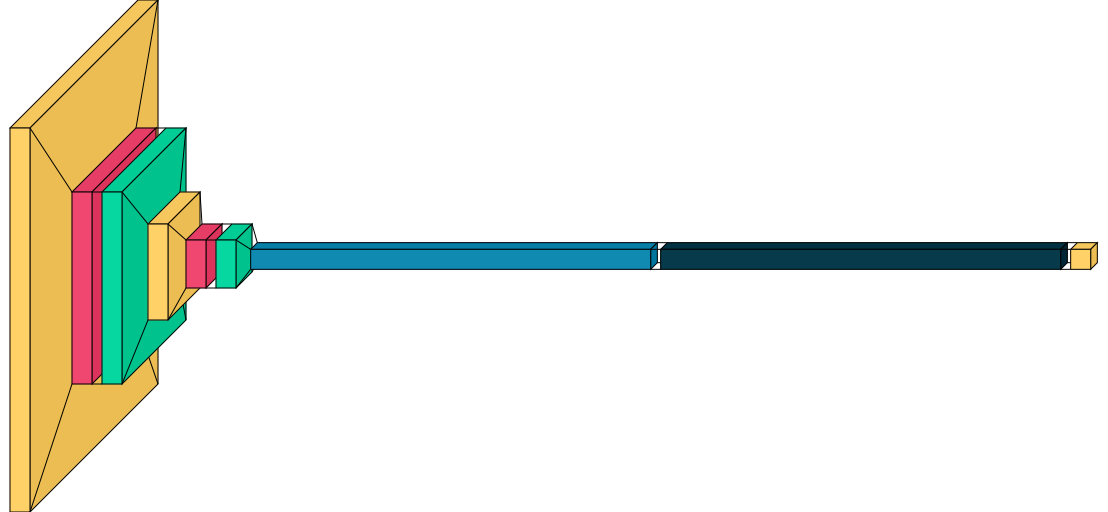

In [59]:
visualkeras.layered_view(model)

In [60]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 5 )

C:\installedsoftwares\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
6854/6854 [==============================] - 1850s 270ms/step - loss: 0.4291 - auc: 0.8813 - val_loss: 0.3710 - val_auc: 0.9125
Epoch 2/5
6854/6854 [==============================] - 1278s 186ms/step - loss: 0.3734 - auc: 0.9090 - val_loss: 0.4256 - val_auc: 0.9168
Epoch 3/5
6854/6854 [==============================] - 1278s 187ms/step - loss: 0.3503 - auc: 0.9202 - val_loss: 1.2649 - val_auc: 0.7733
Epoch 4/5
6854/6854 [==============================] - 1278s 186ms/step - loss: 0.3303 - auc: 0.9290 - val_loss: 0.3338 - val_auc: 0.9318
Epoch 5/5
6854/6854 [==============================] - 1260s 184ms/step - loss: 0.3188 - auc: 0.9340 - val_loss: 0.2975 - val_auc: 0.9489


### (b) Second Model

Modififications to the earlier model are as follows:

1. One Additional Hidden Layer
2. Optimizer Changed to RMSprop

In [61]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.001), loss = 'binary_crossentropy',
              metrics = ['AUC'])

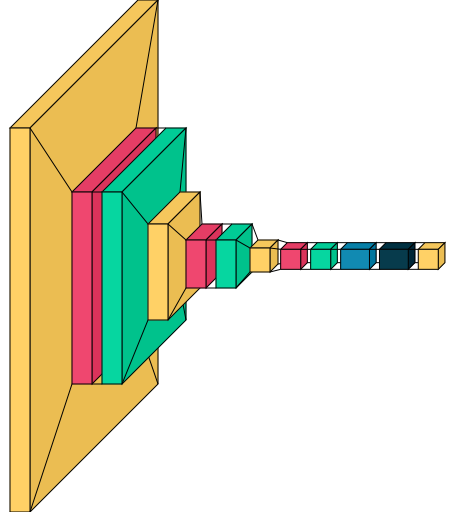

In [62]:
visualkeras.layered_view(model)

In [63]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 5 )

Epoch 1/5
6854/6854 [==============================] - 1247s 182ms/step - loss: 0.3750 - auc: 0.9085 - val_loss: 1.1596 - val_auc: 0.7799
Epoch 2/5
6854/6854 [==============================] - 1282s 187ms/step - loss: 0.3126 - auc: 0.9374 - val_loss: 0.4756 - val_auc: 0.9032
Epoch 3/5
6854/6854 [==============================] - 1275s 186ms/step - loss: 0.2855 - auc: 0.9477 - val_loss: 0.4695 - val_auc: 0.8781
Epoch 4/5
6854/6854 [==============================] - 1257s 183ms/step - loss: 0.2697 - auc: 0.9534 - val_loss: 0.2656 - val_auc: 0.9569
Epoch 5/5
6854/6854 [==============================] - 1269s 185ms/step - loss: 0.2578 - auc: 0.9575 - val_loss: 0.3369 - val_auc: 0.9382


### (c) Third Model

Modification to the second model:
    
1. Optimizer changed to Adadelta

In [64]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu' ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = Adadelta(learning_rate=0.05), loss = 'binary_crossentropy',
              metrics = ['AUC'])

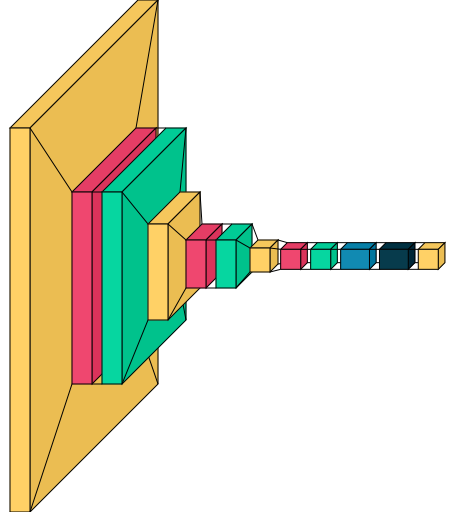

In [65]:
visualkeras.layered_view(model)

In [66]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 5 )

Epoch 1/5
6854/6854 [==============================] - 1412s 206ms/step - loss: 0.4670 - auc: 0.8568 - val_loss: 0.3758 - val_auc: 0.9078
Epoch 2/5
6854/6854 [==============================] - 1800s 263ms/step - loss: 0.3925 - auc: 0.8985 - val_loss: 0.4187 - val_auc: 0.9128
Epoch 3/5
6854/6854 [==============================] - 2383s 348ms/step - loss: 0.3686 - auc: 0.9111 - val_loss: 0.4066 - val_auc: 0.9148
Epoch 4/5
6854/6854 [==============================] - 1321s 193ms/step - loss: 0.3543 - auc: 0.9185 - val_loss: 0.3300 - val_auc: 0.9350
Epoch 5/5
6854/6854 [==============================] - 33929s 5s/step - loss: 0.3413 - auc: 0.9247 - val_loss: 0.3157 - val_auc: 0.9403


## 7. Tuning Hyperparameters of the selected Model

From the above results, we can safely conclude that the best optimizer is RMSprop with 2 hidden layers. The first model might have a better result than the given but still would have lagged some what behind RMSprop and the time complexity of it ade it a relativley poor choice.

After getting the best architecture for our model alongwith the most effective optimizer, we delve into the prospect of tuning the hyperparameters to see if we can further enhecne the effectiveness of our model. The hyperparametes that we will be looking into will be:

1. Learning Rate
2. Decay


In [67]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

### (a) Learning Rate

In [68]:
model.compile(optimizer = RMSprop(learning_rate=0.0025), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [69]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 1297s 189ms/step - loss: 0.3758 - auc: 0.9077 - val_loss: 0.4828 - val_auc: 0.8913


In [70]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.0050), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [71]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 1280s 187ms/step - loss: 0.3879 - auc: 0.9013 - val_loss: 0.4782 - val_auc: 0.9102


In [72]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.0090), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [73]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 6413s 936ms/step - loss: 0.3899 - auc: 0.9003 - val_loss: 0.6094 - val_auc: 0.9135


### (b) Decay

In [76]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.005, decay =0.2), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [77]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 1899s 277ms/step - loss: 0.4831 - auc: 0.8428 - val_loss: 0.4268 - val_auc: 0.8779


In [78]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.005,decay =0.5), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [79]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 1408s 205ms/step - loss: 0.5253 - auc: 0.8136 - val_loss: 0.4707 - val_auc: 0.8496


In [80]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.005, decay =0.8), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [81]:
model.fit_generator(training_gen , validation_data = valid_gen,
                   epochs = 1 )

6854/6854 [==============================] - 1451s 212ms/step - loss: 0.5264 - auc: 0.8171 - val_loss: 0.4711 - val_auc: 0.8508


## 8. Results and Analysis

### (a) Optimizer Comparison(slight layer change also used)

In [83]:
## Adam
epoch1 = [1,2,3,4,5]
train_loss1 = [0.43,0.37,0.35,0.33,0.32]
train_score1 = [0.88,0.91,0.92,0.93,0.93]
val_loss1 = [0.37,0.43,1.26,0.33,0.30]
val_score1 = [0.91,0.92,0.77,0.93,0.95]

## RMSprop
epoch2 = [1,2,3,4,5]
train_loss2 = [0.38,0.31,0.29,0.27,0.26]
train_score2 = [0.91,0.94,0.95,0.95,0.96]
val_loss2 = [1.16,0.48,0.47,0.27,0.34]
val_score2 = [0.78,0.90,0.88,0.96,0.94]

## Adadelta
epoch3 = [1,2,3,4,5]
train_loss3 = [0.47,0.39,0.37,0.35,0.34]
train_score3 = [0.86,0.90,0.91,0.92,0.92]
val_loss3 = [0.38,0.42,0.41,0.33,0.32]
val_score3 = [0.91,0.91,0.91,0.94,0.94]

In [84]:
dict1 = {'epoch': epoch1, 'tr_loss': train_loss1, 'tr_score': train_score1,
         'val_loss': val_loss1, 'val_score': val_score1} 
df_adam = pd.DataFrame(dict1)
df_adam

,epoch,tr_loss,tr_score,val_loss,val_score
0,1,0.43,0.88,0.37,0.91
1,2,0.37,0.91,0.43,0.92
2,3,0.35,0.92,1.26,0.77
3,4,0.33,0.93,0.33,0.93
4,5,0.32,0.93,0.30,0.95


In [85]:
dict2 = {'epoch': epoch2, 'tr_loss': train_loss2, 'tr_score': train_score2,
         'val_loss': val_loss2, 'val_score': val_score2} 
df_rmsprop= pd.DataFrame(dict2)
df_rmsprop

,epoch,tr_loss,tr_score,val_loss,val_score
0,1,0.38,0.91,1.16,0.78
1,2,0.31,0.94,0.48,0.90
2,3,0.29,0.95,0.47,0.88
3,4,0.27,0.95,0.27,0.96
4,5,0.26,0.96,0.34,0.94


In [86]:
dict3 = {'epoch': epoch3, 'tr_loss': train_loss3, 'tr_score': train_score3,
         'val_loss': val_loss3, 'val_score': val_score3} 
df_adadelta = pd.DataFrame(dict1)
df_adadelta

,epoch,tr_loss,tr_score,val_loss,val_score
0,1,0.43,0.88,0.37,0.91
1,2,0.37,0.91,0.43,0.92
2,3,0.35,0.92,1.26,0.77
3,4,0.33,0.93,0.33,0.93
4,5,0.32,0.93,0.30,0.95


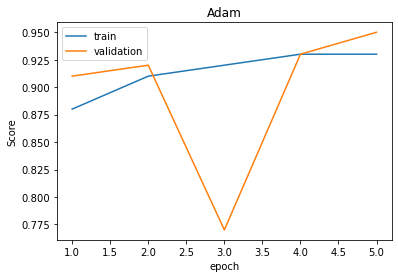

In [90]:
# Adam
plt.plot(epoch1 , train_score1)
plt.plot(epoch1 , val_score1)
plt.title("Adam")
plt.xlabel("epoch")
plt.ylabel("Score")
plt.legend(['train', 'validation'])
plt.show()

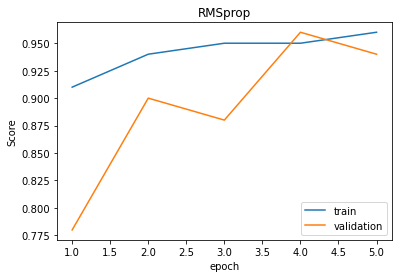

In [91]:
# Rmsprop
plt.plot(epoch1 , train_score2)
plt.plot(epoch1 , val_score2)
plt.title("RMSprop")
plt.xlabel("epoch")
plt.ylabel("Score")
plt.legend(['train', 'validation'])
plt.show()

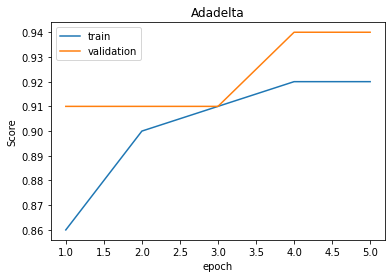

In [92]:
# Adadelta
plt.plot(epoch1 , train_score3)
plt.plot(epoch1 , val_score3)
plt.title("Adadelta")
plt.xlabel("epoch")
plt.ylabel("Score")
plt.legend(['train', 'validation'])
plt.show()

### (b) Learning Rate

In [93]:
Learning_Rate = [0.0025, 0.005, 0.009]
train_loss = [0.38,0.39,0.39]
train_score = [0.91,0.9,0.9]
val_loss = [0.48,0.48,0.61]
val_score = [0.89,0.91,0.91]

In [95]:
dic = {'Learning Rate': Learning_Rate, 'tr_loss': train_loss, 'tr_score': train_score,
         'val_loss': val_loss, 'val_score': val_score} 
df_lr = pd.DataFrame(dic)
df_lr

,Learning Rate,tr_loss,tr_score,val_loss,val_score
0,0.0025,0.38,0.91,0.48,0.89
1,0.0050,0.39,0.90,0.48,0.91
2,0.0090,0.39,0.90,0.61,0.91


### (c) Decay

In [100]:
decay = [0.2,0.5,0.8]
mtrain_loss = [0.48,0.53,0.53]
mtrain_score = [0.84,0.81,0.81]
mval_loss = [0.43,0.47,0.47]
mval_score = [0.88,0.85,0.85]

In [101]:
dicd = {'Decay': decay, 'tr_loss': mtrain_loss, 'tr_score': mtrain_score,
         'val_loss': mval_loss, 'val_score': mval_score} 
df_d = pd.DataFrame(dicd)
df_d

,Decay,tr_loss,tr_score,val_loss,val_score
0,0.2,0.48,0.84,0.43,0.88
1,0.5,0.53,0.81,0.47,0.85
2,0.8,0.53,0.81,0.47,0.85


### (d) Result Summary

After testing the various parameters and hyperparameters, we can safely say that we have a fairly good model depicting a descent amount of ROC score on the validation set. The accuracy also seems to be congruent with the results of the training data depicting that there isn't any overfitting in our data. We have 2 optimizers which are giving quite competetive scores namely RMSprop and Adadelta. however, for our scenario we will be sing the RMSprop as the final optimizer since it is giving the highest score at an instance compared to the steady predictive capability of the Adadelta.

Our best model has the following design in summary:

1. Initial Layer with Convolution, Max Pooling and Batch Normalization
2. First Hidden Layer with Convolution, Max Pooling and Batch Normalization
3. Second Hidden Layer with Convolution, Max Pooling and Batch Normalization
4. Data Flattening
5. Data Dropout
6. Dense Layer with sigmoid activation before output layer

The adjustment of the learning rate gave us a sligh improvement in our result when it was selected to 0.005. Furthermore, the decay hyperparameter does not seem to be having a positive effect on our but rather seems to be deprecating the accuracy. hence, its better if we keep it to the default 0 value. the probable reason why the decay hyperparamter is not working well is since we are using a substantively smaller learningn rate. If we increase the learning rate and then use the decay, we might be able to get some better result.

In [156]:
model = Sequential()

## Initial Layer
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## First Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

## Second Hidden Layer
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 2, padding = 'Same', activation = 'relu', ))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = RMSprop(learning_rate=0.005), loss = 'binary_crossentropy',
              metrics = ['AUC'])

In [157]:
model.fit(training_gen , validation_data = valid_gen,
                   epochs = 5 )

Epoch 1/5
6854/6854 [==============================] - 1506s 220ms/step - loss: 0.3771 - auc: 0.9073 - val_loss: 0.4400 - val_auc: 0.8938
Epoch 2/5
6854/6854 [==============================] - 1402s 205ms/step - loss: 0.3263 - auc: 0.9319 - val_loss: 0.4166 - val_auc: 0.9171
Epoch 3/5
6854/6854 [==============================] - 1384s 202ms/step - loss: 0.3058 - auc: 0.9402 - val_loss: 0.4709 - val_auc: 0.9009
Epoch 4/5
6854/6854 [==============================] - 1342s 196ms/step - loss: 0.2949 - auc: 0.9444 - val_loss: 0.4113 - val_auc: 0.9182
Epoch 5/5
6854/6854 [==============================] - 1352s 197ms/step - loss: 0.2844 - auc: 0.9484 - val_loss: 0.3271 - val_auc: 0.9342


In [158]:
model.save("final_model_trained.h5")

## 9. Using the final model on test data for kaggle submission

In [159]:
gen_test_data = gen.flow_from_directory('test_data_sub',
                                       target_size=(96,96),
                                       batch_size=1,
                                       class_mode='categorical')

Found 57458 images belonging to 1 classes.


In [160]:
final_model = load_model("final_model_trained.h5")
t_pred = final_model.predict_generator(gen_test_data, steps=57458)

C:\installedsoftwares\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [161]:
non_cancer = (1 - t_pred).round()
submission=pd.DataFrame(non_cancer, columns=['label'])
submission['id']=gen_test_data.filenames
submission['id']=submission['id'].str.split('\\', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0] 
submission.set_index('id', inplace=True)
submission.to_csv('final_kaggle_submission.csv')

## 10. Conculsion

The CNN seems to be quite effective in classification of images. Even tweaking of the architecture in a trivial manner seems to be generating quite an effective result. The most important take away is the need to test various architectures but for that, a substantive amount of computing power is required. The limitation in this regard was assessed a lot in this project. To counter this and continue to test complex and powerful model architecture, it might be a better option to use online tools such as the google colab which can help reduce the computing time by using the vast GPUs provided at the platform. Due to the limitation of the GPU, the epoch was limited to 5 only as it was consuming a huge amount of time on my local machine and if we use colab, we might be able to improve the result by simply increasing the amount of epochs even.